Aviva Blonder
STAT 339
Homework 1

# 3. Implementing a Regression Solver from Scratch.

In [1]:
# ensure that plots show up in the document instead of a separate window
% matplotlib inline
# import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

## a) Write a function that takes in a data set of ordered pairs and returns the OSL coefficients for a linear model of the form $ t_n = w_0 + w_1 * x_n $

In [2]:
def regression(data):
    """Finds the optimal weights to fit a linear regression model given the provided data."""
    
    # first, I need the average values of x and t, which are both computed by numpy's mean function
    avg = np.mean(data, 0)
    # now to calculate the optimal weight values using the equation we discussed in class
    w1 = np.sum((data[:, 0] - avg[0])*(data[:, 1] - avg[1]))/np.sum(((data[:, 0] - avg[0]))**2)
    w0 = avg[1] - w1*avg[0]
    
    # return the weight matrix calculated using the equation we derived in class
    return (w0, w1)

## b) Test the regression function using winning race times from the Olympic women’s 100m event in various years

(40.9241546006539, -0.015071812237272305)


/home/gryfalconess/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


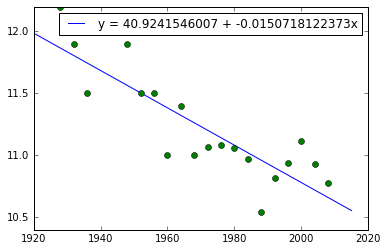

In [3]:
# load the data into a numpy array
womens100 = np.loadtxt("womens100.csv", delimiter = ',')

# run the regression function and get the parameters for a linear model
weights = regression(womens100)
print(weights)

# plot the line and the data that created it to make sure it worked
# first, create a range of x values to plot the line over
xvals = range(1920, 2016)
# now plot the line
plt.plot(xvals, weights[0] + weights[1]*xvals)
# and the data over it
plt.plot(womens100[:, 0], womens100[:, 1], 'o')
plt.legend(["y = " + str(weights[0]) + " + " + str(weights[1]) + "x"])
plt.show()

For comparison, the scipy linear regression solver returns:

In [4]:
# run the regressor
results = sps.linregress(womens100[:, 0], womens100[:, 1])

print("y = " + str(results[1]) + " + " + str(results[0]) + "x")

y = 40.9241546007 + -0.0150718122373x


## c) Use the model to predict the winning times for the 2012 and 2016 Olympics and compare to the actual times

My model predicts that the winning time in 2012 should be:

In [5]:
print(weights[0] + weights[1]*2012)

10.5996683793


And the winning time in 2016 should be:

In [6]:
print(weights[0] + weights[1]*2016)

10.5393811303


The actual winning time in 2012 was 10.75.
The winning time in 2016 was 10.71.

My model underestimated the winning times in both years, but it did correctly predict that the winning time in 2016 would be less than the winning time in 2012.

## d) Modify the linear regression function to allow for multiple input variables and to enable the user to extend the data to a desired order.

In [7]:
def polyreg(data, col = 1, order = 1, reg = 0):
    """Finds the optimal weights to fit a polynomial model given the provided data.
    The user can designate a column to extend and an order to extend it to, as well as a regularization parameter."""
    
    # separate the targets into their own column vetor
    targets = data[:, 0]
    
    # extend the data in col to the user designated order
    for o in range(2, order+1):
        data = np.append(data, data[:, col, np.newaxis]**o, axis = 1)
    
    # if the order is 0, just make the feature matrix a column of ones
    if order == 0:
        features = np.ones((data.shape[0], 1))
    # otherwise add a column of ones before the first feature to use to calculate the intercept
    # and make the feture matrix everything except for the column of targets
    else:
        features = np.insert(data, 1, np.ones(data.shape[0]), 1)[:, 1:]
    
    # return the weight matrix calculated using the equation we derived in class
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(features), features)+reg*np.identity(features.shape[1])), np.transpose(features)), targets)

## e) Apply the generalized function to a new data set, extend it, and plot the resulting curve.

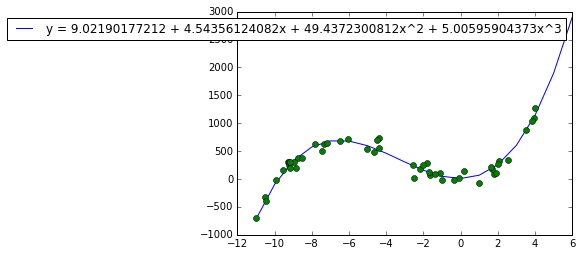

In [8]:
# import the data set
synthdata = np.loadtxt("synthdata2016.csv", delimiter = ',')
# swap the order of the target and the feature so it can easily be used with the polynomial regression function above
sd = synthdata[:, [1, 0]]

def graphpolyreg(data, regparam = 0):
    """ Fits a 3rd order model and graphs it for a given regularization parameter."""

    # fit a model extended to order 3
    weights = polyreg(data, order = 3, reg = regparam)
    
    # create a range of x values to plot the data over
    xvals = np. arange(-11, 7)
    # plot the curve
    plt.plot(xvals, weights[0] + weights[1]*xvals + weights[2]*(xvals**2) + weights[3]*(xvals**3))
    plt.plot(data[:, 1], data[:, 0], 'o')
    plt.legend(["y = " + str(weights[0]) + " + " + str(weights[1]) + "x + " + str(weights[2]) + "x^2 + " + str(weights[3]) + "x^3"])
    plt.show()
    
graphpolyreg(sd)

## f)  Compare results for various choices of the regularization paramter using a cubic model.

The fit above was made with a parameter value of 0, if instead the same data is modeled with a regularization paramter of 1, I get the results below:

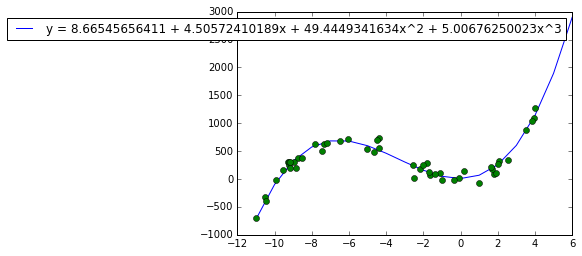

In [9]:
graphpolyreg(sd, 1)

That doesn't look very different, what about a parameter value of 10? 

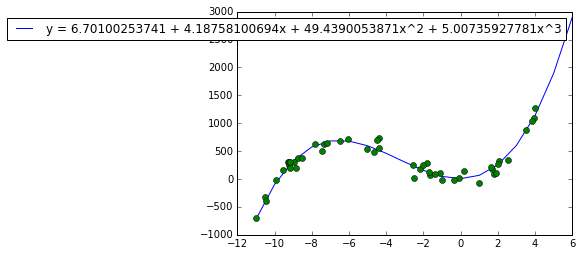

In [10]:
graphpolyreg(sd, 10)

Or 100?

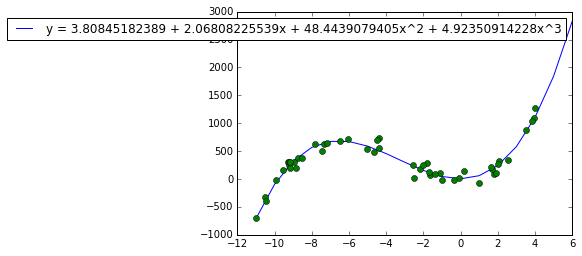

In [11]:
graphpolyreg(sd, 100)

In fact, the function only starts looking really different around a regularization parameter of 10,000!

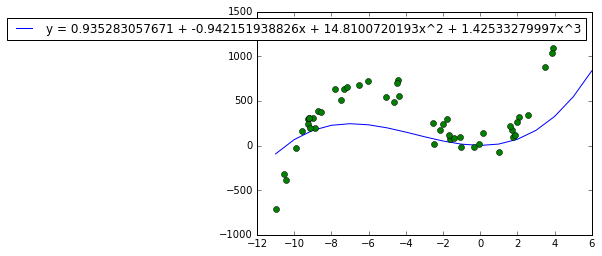

In [12]:
graphpolyreg(sd, 10000)

# 4. Cross-Validation with Regression.

## a) Write a function that performs K-fold cross-validation for the linear regression model.

In [13]:
def validation(targets, features, regparam, K, o = 1):
    """ Performs K-fold cross-validation for a regression model given the targets, features, regularization
    parameter, order, and a value of K. Returns the mean and standard deviation of the mean squared error for
    training and validation sets. Workflow modified from validation procedure in problem #1. """
    
    # attach the targets to the front of the feature matrix
    data = np.append(targets, features, axis = 1)
    # seed random so it doesn't shuffle the data differently each time
    np.random.seed(1)
    # randomize the order of the observations
    np.random.shuffle(data)
    
    # to create K folds, first I need to determine where to split trainset
    foldsize = data.shape[0]/K
    # the training set may not divide evenly, so I need to get the base size and the number of instances leftover
    basesize = int(foldsize)
    leftovers = (foldsize-basesize)*K
    # variables to hold the start and end of each fold
    foldstart = 0
    foldend = 0
    # and empty lists to hold the sum squared error for the training and validation sets
    validsqerror = np.empty(0)
    trainsqerror = np.empty(0)
    
    # now to create and test a linear regression model for each fold
    for fold in range(K):
        # if fold is less than the number of extra instances, one of them gets included in this fold
        if fold < leftovers:
            foldend += basesize + 1
        # otherwise just add the normal number of instances
        else:
            foldend += basesize
        # create the training set for this fold
        trainfold = np.append(data[:foldstart], data[foldend:], 0)
        # and the test set
        testfold = data[foldstart:foldend]
        
        # get the weight vector from fitting a linear model to the training set with the provided order and 
        # regularization parameter
        weights = polyreg(trainfold, reg = regparam, order = o)
        
        # if the order is 0, just make the training features a vector of ones
        if o == 0:
            trainfeatures = np.ones((trainfold.shape[0], 1))
            testfeatures = np.ones((testfold.shape[0], 1))
        # otherwise insert a column of ones between the target and the features for calculating the predicted value
        # and remove the targets
        else:
            trainfeatures = np.insert(trainfold, 1, np.ones(1), axis = 1)[:, 1:]
            testfeatures = np.insert(testfold, 1, np.ones(1), axis = 1)[:, 1:]
        
        # add on the squared error for the training set
        trainsqerror = np.append(trainsqerror, (trainfold[:, 0]-np.dot(weights, np.transpose(trainfeatures)))**2)
        # and validation set
        validsqerror = np.append(validsqerror, (testfold[:, 0]-np.dot(weights, np.transpose(testfeatures)))**2)
        
        # set foldstart equal to foldend for the next fold
        foldstart = foldend
    
    # create a list to put all of the values I'll be returning into
    vals = np.empty(0)
    # now add the mean training and validation error
    vals = np.append(vals, np.mean(trainsqerror))
    vals = np.append(vals, np.mean(validsqerror))
    # and the standard deviation from the mean
    vals = np.append(vals, np.sqrt(np.sum((trainsqerror-vals[0])**2)/(trainsqerror.shape[0]-1)))
    vals = np.append(vals, np.sqrt(np.sum((validsqerror-vals[1])**2)/(validsqerror.shape[0]-1)))
    
    # now to return all of those values
    return np.reshape(vals, (1, 4))

## b) Write a function that performs K-fold cross-validation for the polynomial regression model up to a user designated order.

In [14]:
def polyvalid(targets, features, regparam, K, orderD):
    """ Performs K-fold cross-validation for polynomial regression models through orderD, given the targets, features,
    regularization parameter, and a value of K. Returns the mean and standard deviation of the mean squared error
    for training and validation sets for each order from 0 to orderD. """
    
    # array to hold means and standard deviations
    results = np.empty((orderD, 4))
    
    # for each order from 0 to orderD 
    for order in range(0, orderD):
        # if the order is 0 or one
        if order == 0 or order == 1:
            # just run K-fold cross validation and add the results to the results array
            results[order] = validation(targets, features, regparam, K, o = order)
        # otherwise
        else:
            # extend the data to order
            features = np.append(features, (features[:, 0]**order).reshape(features.shape[0], 1), axis = 1)
            # then run K-fold cross-validation as though the order was one and add to the results array
            results[order] = validation(targets, features, regparam, K)
    
    # return the matrix of results for each order
    return results

## c) Apply the above function to the two data sets used previously to identify the optimal polynomial order.

To do so, I'll create a function that takes in a data set, runs the polynomial cross-validation function on it, and prints out a graph of the results.

In [15]:
def validgraph(data, K, maxorder, regparam = 0):
    """ Makes it easy to run K-fold cross-validation on a range of data sets and orders, and graph the results. """
    
    # separate out the features and targets to send them through the validation function
    targets = np.expand_dims(data[:, 1], 1)
    features = np.expand_dims(data[:, 0], 1)
    
    # run the polynomial cross-validation function on the data with the given parameters
    results = polyvalid(targets, features, regparam, K, maxorder)

    # graph the results
    plt.plot(np.arange(maxorder), results[:, 0], 'r', np.arange(maxorder), results[:, 1], 'b')
    plt.legend(["training", "validation"])
    plt.xlabel("Order")
    plt.ylabel("Average Squared Error")
    plt.show()

First, I'll try it out on the synthdata data set, which I previously fit to a 3rd order model. I'll use a K of 10 for cross-validation.

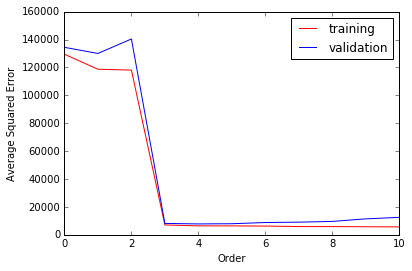

In [16]:
validgraph(synthdata, 10, 11)

It looks like the optimal order is in fact 3. After that, the validation error starts to increase, even though the training error continues to decrease.

What if I set K equal to the number of instances in the data set (aka. leave-one-out cross-validation)?

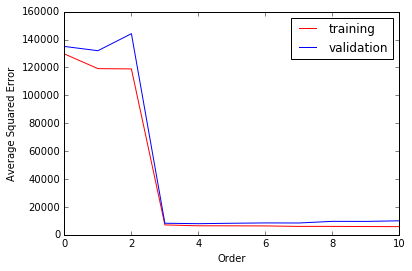

In [17]:
validgraph(synthdata, synthdata.shape[0], 11)

It looks like the optimal order is 3 either way.

Next, I'll run 10-fold cross-validation on the data set of winning times from the Olympic women’s 100m race over several years, to figure out the optimal order to fit it.

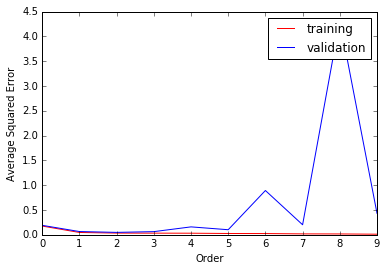

In [25]:
# first, normalize the x values by subtracting the maximum so that they don't get too big
womensnorm = np.append((womens100[:, 0]-np.min(womens100[:, 0])).reshape(womens100.shape[0], 1), womens100[:, 1].reshape(womens100.shape[0], 1), axis = 1)
validgraph(womensnorm, 10, 10)

Those spikes in validation error make it hard to see what's going on before them. If I zoom in on the error for orders 0 to 3, I get a smoother looking curve:

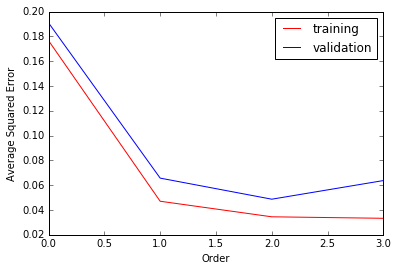

In [34]:
validgraph(womensnorm, 10, 4)

From this, it appears that the optimal order is around 2, before the validation error begins to increase.

Leave-one-out cross-validation results in the following average error for orders 0 to 10:

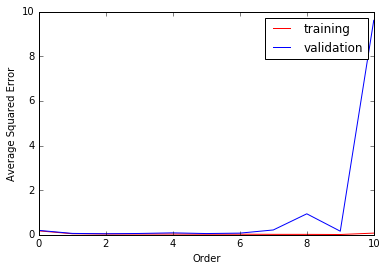

In [27]:
validgraph(womensnorm, womensnorm.shape[0], 11)

If I zoom in on orders 0 through 3 again, I get a similar plot to before, which illustrates an optimal order of 2, as 10-fold cross-validation did.

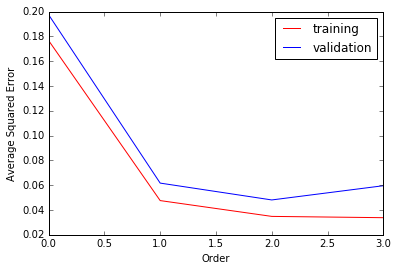

In [28]:
validgraph(womensnorm, womensnorm.shape[0], 4)

## d) Use the 2012 and 2016 winning times as a test set for the data set of winning times from the Olympic women's 100m race with different polynomial orders.

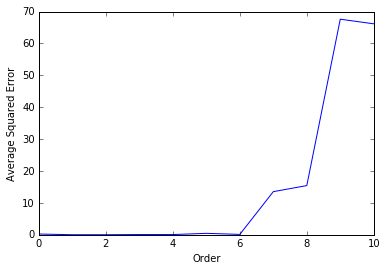

In [29]:
# I'll build up the trainset for each order, starting with the womens100 dataset
trainset = womensnorm[:, [1, 0]]
# I'll also build up the testset
testset = np.ones((2, 1))

# an empty list to hold the error for the predictions
testerror = np.empty(0)

# for each polynomial order from 0 to 10, make predictions for 2012 and 2016 and compare them to the actual outcomes
for o in range(11):
    # if the order is 0 or 1, just send it through as is
    if o <= 1:
        weights = polyreg(trainset, order = o)
    # otherwise, add on a column, and then send it through
    else:
        trainset = np.append(trainset, np.reshape(trainset[:, 1]**o, (trainset.shape[0], 1)), axis = 1)
        weights = polyreg(trainset)
    
    # if the order is greater than 0, build up the test set
    if o > 0:
        testset = np.append(testset, np.reshape((np.array([2012, 2016])-np.min(womens100[:, 0]))**o, (2, 1)), axis = 1)
    # calculate the predicted winning times for 2012 and 2016
    predwins = np.dot(weights.reshape(1, weights.shape[0]), np.transpose(testset))
    # calculate the mean error and add it to the list of errors
    testerror = np.append(testerror, np.mean((predwins-np.array([10.75, 10.71]))**2))
    

# graph the error over the order
plt.plot(np.arange(11), testerror)
plt.xlabel("Order")
plt.ylabel("Average Squared Error")
plt.show()

Zooming in on the range from order 0 to 3, we can see that the optimal order is 2, as was suggested by cross-validation.

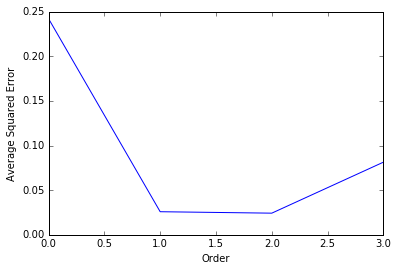

In [30]:
# graph the error over the order
plt.plot(np.arange(4), testerror[: 4])
plt.xlabel("Order")
plt.ylabel("Average Squared Error")
plt.show()

## e) Use 10-fold cross-validation and a grid search to find the optimal combination of order and regularization parameter for the data set of winning times for the Olympic women's 100m race.

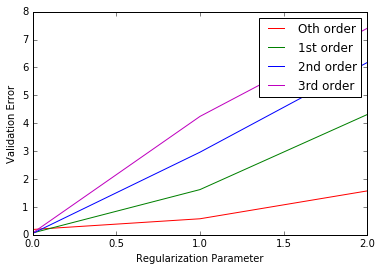

In [37]:
# matrix to hold the mean error and standard deviations for each combination of values
results = np.empty((3, 4, 4))

# loop through a range of regularization parameters to call the polynomial validation function with
for reg in range(3):
    results[reg, :, :] = polyvalid(np.reshape(womensnorm[:, 1], (womensnorm.shape[0], 1)),
                                   np.reshape(womensnorm[:, 0], (womensnorm.shape[0], 1)), reg, 10, 4)
    
# plot the results
plt.plot(np.arange(3), results[:, 0, 1], 'r', np.arange(3), results[:, 1, 1], 'g',
         np.arange(3), results[:, 2, 1], 'b', np.arange(3), results[:, 3, 1], 'm')
plt.legend(["Oth order", "1st order", "2nd order", "3rd order"])
plt.xlabel("Regularization Parameter")
plt.ylabel("Validation Error")
plt.show()

Looking at the plot, the optimal regularization parameter appears to be 0. The maximum order seems to be tied between 1st, 2nd, and 3rd. Looking in at all three orders with a regularization parameter of 0, their mean validation error is:

In [38]:
print("1st order: " + str(results[0, 1, 1]))
print("2nd order: " + str(results[0, 2, 1]))
print("3rd order: " + str(results[0, 3, 1]))

1st order: 0.0657082551869
2nd order: 0.0487122228506
3rd order: 0.063737047239


It looks like the best combination is 2nd order with a regularization parameter of 0, according to 10-fold cross-validation.

Now, I can try this model out on the test set of running times from 2012 and 2016.

In [33]:
# find the optimal weights for a model with the optimal parameter values.
weights = polyreg(womensnorm[:, [1, 0]], order = 2)
# create a testing set
testset = np.array([[1, 2012-1928, (2012-1928)**2], [1, 2016-1928, (2016-1928)**2]])
# calculate average squared error
error = np.mean((np.array([10.75, 10.71])-np.dot(np.reshape(weights, (1, 3)), np.transpose(testset)))**2)
print("The average squared error for the optimal model is: " + str(error))
print("For comparison, the average squared error for the linear model is: " + str(testerror[1]))

The average squared error for the optimal model is: 0.0242367708885
For comparison, the average squared error for the linear model is: 0.0258551974435


# 5. Deriving a Weighted Least Squares Regression Fit.

Derive an expression for the estimated weight vector that minimizes
$$ \mathcal{L}(w; x, t) = \frac{1}{N} \sum_{n=1}^{N} \alpha_n(t_n - w^{\top}x_n)^2 $$

To find the weight vector that minimizes loss, we must first set the partial derivative of the loss function with respect to the weights equal to 0. Using the chain rule:
$$ \frac{\partial \mathcal{L}}{\partial w} = \frac{2}{N} \sum_{n=1}^{N} \alpha_n(t_n - \hat{w}^{\top}x_n)(-x_n) = 0 $$
Because everything has been set equal to 0, the fraction out front can be ignored, as that cannot be equal to 0, so after distributing we are left with:
$$ \sum_{n=1}^{N} (-\alpha_nt_nx_n + \alpha_n\hat{w}^{\top}x_nx_n) = 0 $$
We can now move the term containing the weight vector to the other side:
$$ \sum_{n=1}^{N} \alpha_nt_nx_n = \sum_{n=1}^{N} \alpha_n\hat{w}^{\top}x_nx_n $$
This is equivalent to:
$$ AtX = A\hat{w}^{\top}XX $$
Where A is a matrix whose nth row and nth column are equal to the nth value of alpha for all n from 1 to N, all other values of A are equal to 0. X is a matrix whose nth column is $ x_n $.
If we multiply both sides by $ A^{-1}X^{-1}X^{-1} $ and transpose both sides, we get:
$$ \hat{w} = (tX^{-1})^{\top} $$